# NISQ Experiment

In [1]:
import sys
sys.path.insert(0, '../../src_tf/')

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tqdm.notebook import tqdm

from loss_functions import *
from optimization import *
from quantum_channel import *
from quantum_tools import *
from quantum_gates import *

#np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(precision=4)

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

In [2]:
import numpy as np
import tensorflow as tf
from copy import copy, deepcopy
from scipy.linalg import expm
from utils import *


def swap_unitary(n, q1, q2):
    zero_zero = tf.convert_to_tensor([[1, 0], [0, 0]], dtype=tf.complex128)
    zero_one = tf.convert_to_tensor([[0, 1], [0, 0]], dtype=tf.complex128)
    one_zero = tf.convert_to_tensor([[0, 0], [1, 0]], dtype=tf.complex128)
    one_one = tf.convert_to_tensor([[0, 0], [0, 1]], dtype=tf.complex128)

    d1 = 2**q1
    d2 = 2 ** (q2 - q1 - 1)
    d3 = 2 ** (n - q2 - 1)

    I_d1 = tf.eye(d1, dtype=tf.complex128)
    I_d2 = tf.eye(d2, dtype=tf.complex128)
    I_d3 = tf.eye(d3, dtype=tf.complex128)

    zero_zero_full = kron(I_d1, zero_zero, I_d2, zero_zero, I_d3)
    zero_one_full = kron(I_d1, zero_one, I_d2, one_zero, I_d3)
    one_zero_full = kron(I_d1, one_zero, I_d2, zero_one, I_d3)
    one_one_full = kron(I_d1, one_one, I_d2, one_one, I_d3)

    U = zero_zero_full + zero_one_full + one_zero_full + one_one_full

    return U


def pad_unitary(U, n, target_qubits):
    if not isinstance(target_qubits, list):
        target_qubits = [target_qubits]
    d = U.shape[1]
    num_qubits = int(np.log2(d))

    if num_qubits != len(target_qubits):
        raise ValueError("Gate and target qubits are incompatible")

    q1 = target_qubits[0]
    d1 = 2**q1
    d2 = 2 ** (n - q1 - len(target_qubits))

    U = kron(tf.eye(d1), U)
    U = kron(U, tf.eye(d2))

    if num_qubits > 1:
        q2 = target_qubits[1]
        if q2 != q1 + 1:
            U_swap = swap_unitary(n, q1 + 1, q2)
            U = U_swap @ U @ U_swap

    return U


class Gate:
    def get_unitary(self, n):
        raise NotImplementedError

    def __call__(self, state):
        U = self.get_unitary()
        return tf.linalg.matvec(U, state)


class CNOT(Gate):
    def __init__(self, n, target_qubits):
        self.n = n
        self.target_qubits = target_qubits

    def get_unitary(self):
        U = tf.convert_to_tensor(
            [[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 0, 1], [0, 0, 1, 0]],
            dtype=tf.complex128,
        )
        U = pad_unitary(U, self.n, self.target_qubits)
        return U


class Ry(Gate):
    def __init__(self, theta, n, target_qubits):
        self.theta = theta
        self.n = n
        self.target_qubits = target_qubits

        if not isinstance(self.target_qubits, list):
            self.target_qubits = [self.target_qubits]

        self.I = tf.convert_to_tensor(np.array([[[1, 0], [0, 1]]], dtype=np.complex128))
        self.Y = tf.convert_to_tensor(np.array([[[0, -1j], [1j, 0]]], dtype=np.complex128))

    def get_unitary(self):
        U = tf.cos(self.theta / 2) * self.I + 1j * tf.sin(self.theta / 2) * self.Y
        U = pad_unitary(U, self.n, self.target_qubits)
        return U


class Rx(Gate):
    def __init__(self, theta, n, target_qubits):
        self.theta = theta
        self.n = n
        if not isinstance(target_qubits, list):
            target_qubits = [target_qubits]
        self.target_qubits = target_qubits

        self.I = tf.convert_to_tensor(np.array([[[1, 0], [0, 1]]], dtype=np.complex128))
        self.X = tf.convert_to_tensor(np.array([[[0, 1], [1, 0]]], dtype=np.complex128))

    def get_unitary(self):
        U = tf.cos(self.theta / 2) * self.I + 1j * tf.sin(self.theta / 2) * self.X
        U = pad_unitary(U, self.n, self.target_qubits)
        return U


class LadderCNOT(Gate):
    def __init__(self, n):
        self.n = n
        self.gate_list = []
        for i in range(self.n - 1):
            cnot = CNOT(self.n, [i, i + 1])
            self.gate_list.append(cnot)

    def __call__(self, state):
        for gate in self.gate_list:
            state = gate(state)

        return state


class LadderRy(Gate):
    def __init__(self, theta_list, n):
        self.theta_list = theta_list
        self.n = n
        self.gate_list = []
        num_features = self.theta_list.shape[1]

        for i in range(self.n):
            i_ = i%num_features
            theta = tf.cast(self.theta_list[:,i_], tf.complex128)
            ry = Ry(theta, self.n, i)
            self.gate_list.append(ry)
    
    def __call__(self, state):
        for gate in self.gate_list:
            state = gate(state)
            
        return state


class LadderRx(Gate):
    def __init__(self, theta_list, n):
        self.theta_list = theta_list
        self.n = n
        self.gate_list = []

        for i in range(self.n):
            theta = tf.cast(self.theta_list[i], tf.complex128)
            rx = Rx(theta, self.n, i)
            self.gate_list.append(rx)

    def __call__(self, state):
        for gate in self.gate_list:
            state = gate(state)

        return state


class QNN:
    def __init__(self, n, num_layers):
        self.n = n
        self.num_layers = num_layers

        self.d = 2**n

        self.params = []
        for i in range(num_layers):
            theta_list = tf.Variable(tf.random.uniform([n, 1, 1], -np.pi, np.pi, dtype=tf.float64), trainable=True)
            self.params.append(theta_list)
        
        #weights = tf.Variable(tf.random.normal([n, 2], dtype=tf.float64), trainable=True)
        #self.params.append(weights)

    def __call__(self, inputs):
        batch_dim = inputs.shape[0]
        state = np.zeros((1, self.d))
        state[0, 0] = 1
        state = tf.convert_to_tensor(state, dtype=tf.complex128)
        state = tf.repeat(state, batch_dim, axis=0)

        inputs = inputs.reshape(*(inputs.shape), 1, 1)
        inputs = tf.cast(inputs, tf.complex128)

        cnotLadder = LadderCNOT(self.n)
        for i in range(self.num_layers):
   
            ry = LadderRy(inputs, self.n)
            rx = LadderRx(self.params[i], self.n)
            state = ry(state)
            state = rx(state)
            if i != self.num_layers - 1:
                state = cnotLadder(state)

        prob = tf.abs(state) ** 2
        prob = prob.reshape(batch_dim, *self.n*[2])
        prob_list = []
        for i in range(self.n):
            prob_list.append(tf.math.reduce_sum(prob, axis=[j for j in range(1, self.n+1) if j != (i+1)]))
        prob_list = tf.stack(prob_list, axis=1)[:, :, 0]
        #weights = self.params[-1]
        #weights = tf.math.sigmoid(weights)
        #prob_list = prob_list@weights
        return prob_list
    

class DNN:
    def __init__(self, num_layers):
        self.num_layers = num_layers
        self.params = []
        for i in range(num_layers):
            theta_list = tf.Variable(tf.random.uniform([1, 1], -np.pi, np.pi, dtype=tf.float64), trainable=True)
            self.params.append(theta_list)


def trajectory_length(outputs):
    dist = tf.norm(outputs[1:] - outputs[:-1])
    return dist
    



In [3]:

tf.random.set_seed(42)
n = 6
N = 1000
qnn = QNN(n, n**2)
t = np.linspace(0, 2*np.pi, N)
inputs = np.pi/2*np.array([np.sin(t), np.cos(t)]).T
state = qnn(inputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)

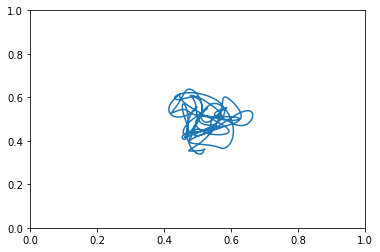

In [4]:
plt.plot(state[:,0], state[:,1])
plt.xlim([0,1])
plt.ylim([0,1])
plt.show()

In [5]:
for i in tqdm(range(1000)):
    with tf.GradientTape() as tape:
        state = qnn(inputs)
        dist = tf.math.sqrt((state[1:,0] - state[:-1,0])**2 + (state[1:,1] - state[:-1,1])**2)
        loss = -tf.reduce_sum(dist)
    grads = tape.gradient(loss, qnn.params)
    optimizer.apply_gradients(zip(grads, qnn.params))
    if i%10 == 0:
        print(loss.numpy())
    

  0%|          | 0/1000 [00:00<?, ?it/s]

-5.322539743230772
-15.164046791732371
-17.076400355346884
-18.1972848474828
-18.657539523622994
-18.984254978931183
-19.09518881118537
-19.15530983854179
-19.313789821812644
-19.464524283955786
-19.658168953684083
-19.720441208437133
-19.79494932226318
-19.722191848751837
-19.90324215688298
-19.898079470434556
-19.911796224339806
-19.915303061577816
-19.919333081406776
-19.923556375950643
-19.92802222087701
-19.931231360528464
-19.79750794188091
-19.930660220017156
-19.934632207550464
-19.93014882855753
-19.938998636306874
-19.9379447503727
-19.93881486933206
-19.939008830677384
-19.929423409511255
-19.934488241090804
-19.922388895451792
-19.925899042816894
-19.935320640393094
-19.9360355678161
-19.939566879531935
-19.936001195652903
-19.838724849320517
-19.923568669956246
-19.939070531574963
-19.93756161327036
-19.939478625247016
-19.936211637932704
-19.933556007091525
-19.877067864548096
-19.926606242168354
-19.9387676726819
-19.925569128876518
-19.927196484299618
-19.92980621557317

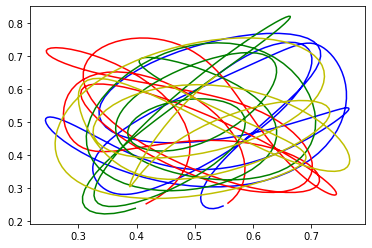

In [6]:
a = 250

plt.plot(state[:a,0], state[:a,1], "b")
plt.plot(state[a:2*a,0], state[a:2*a,1], "r")
plt.plot(state[2*a:3*a,0], state[2*a:3*a,1], "g")
plt.plot(state[3*a:,0], state[3*a:,1], "y")
plt.show()

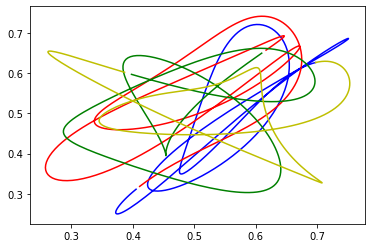

In [20]:
a = 250

plt.plot(state[:a,0], state[:a,1], "b")
plt.plot(state[a:2*a,0], state[a:2*a,1], "r")
plt.plot(state[2*a:3*a,0], state[2*a:3*a,1], "g")
plt.plot(state[3*a:,0], state[3*a:,1], "y")
plt.show()

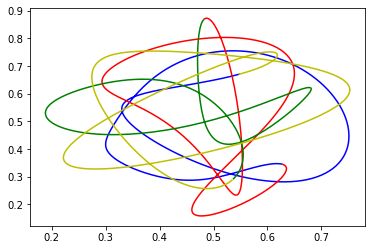

In [330]:
a = 250

plt.plot(state[:a,0], state[:a,1], "b")
plt.plot(state[a:2*a,0], state[a:2*a,1], "r")
plt.plot(state[2*a:3*a,0], state[2*a:3*a,1], "g")
plt.plot(state[3*a:,0], state[3*a:,1], "y")
plt.show()

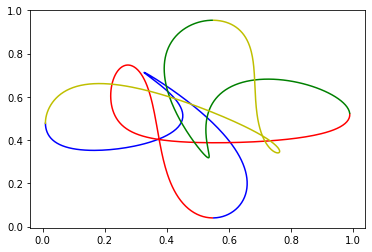

In [313]:
a = 250

plt.plot(state[:a,0], state[:a,1], "b")
plt.plot(state[a:2*a,0], state[a:2*a,1], "r")
plt.plot(state[2*a:3*a,0], state[2*a:3*a,1], "g")
plt.plot(state[3*a:,0], state[3*a:,1], "y")
plt.show()

In [16]:
targets = qnn(inputs)
tf.random.set_seed(42)
qnn2 = QNN(n, 3*n)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)

In [19]:
for i in tqdm(range(100)):
    with tf.GradientTape() as tape:
        state = qnn2(inputs)
        loss = tf.math.reduce_mean((state - targets)**2)
    grads = tape.gradient(loss, qnn2.params)
    optimizer.apply_gradients(zip(grads, qnn2.params))
    if i%10 == 0:
        print(loss.numpy())

  0%|          | 0/100 [00:00<?, ?it/s]

0.0024022514697685958
0.0023905903039858926
0.0023900663553651346
0.0023886630962408066
0.002387779841610219
0.00238722270087814
0.002386539951730786
0.002385732145715161
0.0023847474572332873
0.002383580841208922


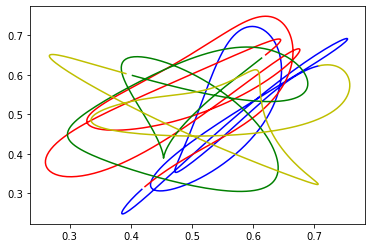

In [18]:
a = 250

plt.plot(state[:a,0], state[:a,1], "b")
plt.plot(state[a:2*a,0], state[a:2*a,1], "r")
plt.plot(state[2*a:3*a,0], state[2*a:3*a,1], "g")
plt.plot(state[3*a:,0], state[3*a:,1], "y")
plt.show()

## Adverserial QNN

In [87]:
n = 5
d = 2**n

N = 1000
t = np.linspace(0, 2*np.pi, N)
inputs = np.pi/2*np.array([np.sin(t), np.cos(t)]).T
inputs = tf.cast(inputs, tf.complex128)

tf.random.set_seed(42)

dnn = tf.keras.Sequential()
dnn.add(tf.keras.layers.Dense(8, activation='relu', input_shape=(2,)))
dnn.add(tf.keras.layers.Dense(8, activation='relu'))
dnn.add(tf.keras.layers.Dense(n, activation='sigmoid'))

qnn = QNN(n, n)

optimizer1 = tf.keras.optimizers.Adam(learning_rate=0.01)
optimizer2 = tf.keras.optimizers.Adam(learning_rate=-0.01)

targets = qnn(inputs)
outputs = tf.cast(dnn(inputs), dtype=tf.complex128)


In [88]:
for i in tqdm(range(1000)):
    with tf.GradientTape(persistent=True) as tape:
        targets = qnn(inputs)
        outputs = tf.cast(dnn(inputs), dtype=tf.complex128)
        loss = tf.math.reduce_mean((outputs - targets)**2)

    
    grads = tape.gradient(loss, [dnn.trainable_variables, qnn.params])
    
    optimizer1.apply_gradients(zip(grads[0], dnn.trainable_variables))
    optimizer2.apply_gradients(zip(grads[1], qnn.params))

    if i%10 == 0:
        print(loss.numpy())

targets = qnn(inputs)
outputs = tf.cast(dnn(inputs), dtype=tf.complex128)


  0%|          | 0/1000 [00:00<?, ?it/s]

(0.02402441554034902-3.2102766396022574e-18j)
(0.014937934098856931-1.6680094006531212e-18j)
(0.016253494777619948-1.852157061472688e-18j)
(0.018122946322853932-2.4816658564810145e-18j)
(0.019420737625940508-2.667448288717064e-18j)
(0.01950304615670053-2.5155622105162004e-18j)
(0.018551662553984414-2.320873620927051e-18j)
(0.01691270136306263-2.080114177007515e-18j)
(0.014755746879369522-1.7555269775743068e-18j)
(0.012837075497379084-1.6073688201059597e-18j)
(0.011075926387044665-1.359739219394926e-18j)
(0.009266082904408005-1.1149808150905553e-18j)
(0.007594866982791106-9.307325742985163e-19j)
(0.006464177012235805-8.202797567011899e-19j)
(0.005886009745862367-7.369084375220541e-19j)
(0.005562529543838572-6.940803606530986e-19j)
(0.005485392437552206-6.9859956513253e-19j)
(0.005764379123221353-7.511635526849736e-19j)
(0.006301604474754134-8.377932681275108e-19j)
(0.006746707381503103-8.682575896320938e-19j)
(0.006595442553208952-8.086078069054649e-19j)
(0.0061231839311062086-7.4855988

c:\Users\krist\anaconda3\envs\env_qiskit\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


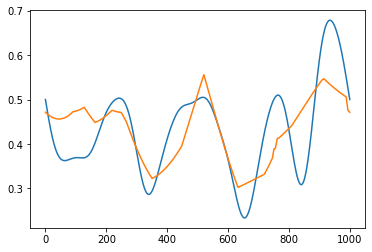

In [90]:
plt.plot(targets[:,1])
plt.plot(outputs[:,1])
plt.show()

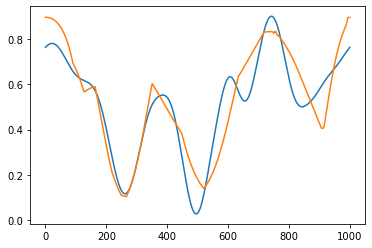

In [91]:
plt.plot(targets[:,2])
plt.plot(outputs[:,2])
plt.show()

## Multidim Trajectory Length

In [56]:
n = 7
d = 2**n

N = 1000
t = np.linspace(0, 2*np.pi, N)
inputs = np.pi/2*np.array([np.sin(t), np.cos(t)]).T
inputs = tf.cast(inputs, tf.complex128)

tf.random.set_seed(42)

qnn = QNN(n, 2*n)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)
outputs1 = qnn(inputs)

In [57]:
for i in tqdm(range(100)):
    with tf.GradientTape() as tape:
        outputs = qnn(inputs)
        loss = -trajectory_length(outputs)
    
    grads = tape.gradient(loss, qnn.params)   
    optimizer.apply_gradients(zip(grads, qnn.params))

    if i%10 == 0:
        print(loss.numpy())

outputs2 = qnn(inputs)


  0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: 

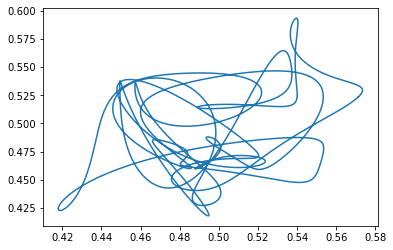

In [59]:
plt.plot(outputs1[:,6], outputs1[:,7])
#plt.plot(outputs2[:,0], outputs2[:,1])


In [61]:
tf.random.set_seed(42)

targets = qnn(inputs)

dnn = tf.keras.Sequential()
dnn.add(tf.keras.layers.Dense(16, activation='relu', input_shape=(2,)))
dnn.add(tf.keras.layers.Dense(16, activation='relu'))
dnn.add(tf.keras.layers.Dense(n, activation='sigmoid'))

optimizer2 = tf.keras.optimizers.Adam(learning_rate=0.01, decay=0.01)

In [62]:
for i in tqdm(range(10000)):
    with tf.GradientTape() as tape:
        outputs = dnn(inputs)
        loss = tf.math.reduce_mean((outputs - targets)**2)
    
    grads = tape.gradient(loss, dnn.trainable_variables)   
    optimizer2.apply_gradients(zip(grads, dnn.trainable_variables))

    if i%10 == 0:
        print(loss.numpy())

  0%|          | 0/10000 [00:00<?, ?it/s]

0.0064363854668713595
0.0010925878643031882
0.0008839766202564457
0.0007902098408354291
0.0007332716186420575
0.0006993774484508054
0.0006754914745292393
0.000655550170817697
0.0006394501330692313
0.0006256655826232767
0.0006144952303407853
0.0006047258711313489
0.0005957251577947672
0.0005873288202356535
0.0005793954445345179
0.0005714999491470902
0.0005631447342829969
0.0005555865616602489
0.0005487034082141537
0.0005388903492311233
0.0005302661264498677
0.0005225330116795648
0.0005153187467192848
0.0005084759207890858
0.0005023420160851353
0.0004961649901575501
0.0004900834162026992
0.0004848555817994656
0.0004801399522292701
0.0004757578822910711
0.00047167802892105615
0.00046785178338077445
0.00046430377564743344
0.0004609229614763414
0.00045765975747242123
0.000454483376380449
0.0004513815974022559
0.00044833214733189166
0.0004453278717913693
0.0004423582354833882
0.00043942714628333066
0.00043652548424279994
0.00043365095974869127
0.0004307980572251763
0.00042797446583147736
0.0

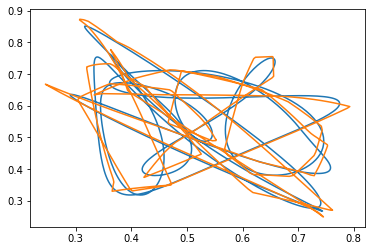

In [55]:
plt.plot(outputs2[:,3], outputs2[:,2])
plt.plot(outputs[:,3], outputs[:,2])